In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yaml import safe_load
import os
from tqdm import tqdm
%matplotlib inline



In [2]:
filenames=[]
for file in os.listdir("C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s"):
     filenames.append(os.path.join("C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s",file))

In [199]:
filenames[0:5]

['C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1001349.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1001351.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1001353.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1004729.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1007655.yaml']

In [200]:
df_final = pd.DataFrame()
counter = 1

# Columns you want to keep
wanted_cols = [
    "innings",
    "meta.data_version",
    "meta.created",
    "meta.revision",
    "info.outcome.bowl_out",
     "info.bowl_out",
    "info.supersubs.South Africa",
    "info.supersubs.New Zealand",
    "info.outcome.eliminator",
    "info.balls_per_over",
    "info.outcome.method",
    "info.official_venue",
    "info.match_type_number",
    "info.city",
    "info.dates",
    "info.gender",
    "info.match_type",
    "info.outcome.by.wickets",
    "info.outcome.by.runs",
    "info.outcome.winner",
    "info.overs",
    "info.player_of_match",
    "info.teams",
    "info.toss.winner",
    "info.toss.decision",
    "info.venue",
    
]

for file in tqdm(filenames):
    with open(file, 'r') as f:
        df = pd.json_normalize(safe_load(f))
        df['match_id'] = counter

        # Keep only wanted columns if they exist
        df = df[[c for c in wanted_cols if c in df.columns] + ['match_id']]

        df_final = pd.concat([df_final, df], ignore_index=True)
        counter += 1
import pandas as pd
from yaml import safe_load
from tqdm import tqdm

all_dfs = []
counter = 1  # optional: to track match_id

for file in tqdm(filenames):
    with open(file, 'r') as f:
        try:
            data = safe_load(f)  # Load YAML/JSON
            
            # Skip empty files
            if not data:
                continue

            # If it's a single dict, wrap it in a list
            if isinstance(data, dict):
                data = [data]

            # Ensure we only normalize if data is a list of dicts
            if isinstance(data, list) and all(isinstance(d, dict) for d in data):
                df = pd.json_normalize(data)
                df['match_id'] = counter
                all_dfs.append(df)
                counter += 1
            else:
                print(f"Skipped file {file}: unsupported structure {type(data)}")
        
        except Exception as e:
            print(f"Error in file {file}: {e}")

# Combine all dataframes into one
if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
else:
    final_df = pd.DataFrame()

print("Final DataFrame shape:", final_df.shape)


  5%|████                                                                           | 233/4571 [00:42<13:13,  5.46it/s]


KeyboardInterrupt: 

In [ ]:
backup = df_final.copy()

In [ ]:
df_final['info.gender'].value_counts()

In [ ]:
df_final = df_final[df_final['info.gender'] == 'male']
df_final.drop(columns=['info.gender'],inplace=True)


In [ ]:
df_final['info.match_type'].value_counts()

In [209]:
import pickle
pickle.dump(df_final,open('dataset_t20.pkl','wb'))

In [2]:
import pickle
matches = pickle.load(open('dataset_t20.pkl','rb'))
matches.iloc[0]['innings'][0]['1st innings']['deliveries']

[{0.1: {'batsman': 'AJ Finch',
   'bowler': 'SL Malinga',
   'non_striker': 'M Klinger',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.2: {'batsman': 'AJ Finch',
   'bowler': 'SL Malinga',
   'non_striker': 'M Klinger',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.3: {'batsman': 'AJ Finch',
   'bowler': 'SL Malinga',
   'non_striker': 'M Klinger',
   'runs': {'batsman': 1, 'extras': 0, 'total': 1}}},
 {0.4: {'batsman': 'M Klinger',
   'bowler': 'SL Malinga',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 2, 'extras': 0, 'total': 2}}},
 {0.5: {'batsman': 'M Klinger',
   'bowler': 'SL Malinga',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.6: {'batsman': 'M Klinger',
   'bowler': 'SL Malinga',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 3, 'extras': 0, 'total': 3}}},
 {1.1: {'batsman': 'M Klinger',
   'bowler': 'KMDN Kulasekara',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 0, 'extras': 0, 'total': 

In [3]:
def get_player_out(info):
    wk = info.get("wicket", None)
    if wk is None:
        return "0"
    
    if isinstance(wk, dict):
        return wk.get("player_out", "0")
    
    if isinstance(wk, list) and len(wk) > 0:
        if isinstance(wk[0], dict):
            return wk[0].get("player_out", "0")
    
    return "0"


delivery_list = []

skip_ids = {75,108,150,180,268,360,443,458,584,748,982,1052,1111,1226,1345}

for idx, row in matches.iterrows():
    
    if idx+1 in skip_ids:
        continue
    
    match_id = idx + 1
    innings = row['innings'][0]['1st innings']
    batting_team = innings['team']
    deliveries = innings['deliveries']

    for ball in deliveries:
        ball_num = list(ball.keys())[0]
        info = ball[ball_num]

        delivery_list.append({
            "match_id": match_id,
            "teams": row["info.teams"],
            "batting_team": batting_team,
            "ball": ball_num,
            "batsman": info["batsman"],
            "bowler": info["bowler"],
            "runs": info["runs"]["total"],
            "player_dismissed": get_player_out(info),
            "city": row["info.city"],
            "venue": row["info.venue"]
        })

delivery_df = pd.DataFrame(delivery_list)


In [4]:
delivery_df

,match_id,teams,batting_team,ball,batsman,bowler,runs,player_dismissed,city,venue
0,1,"[Australia, Sri Lanka]",Australia,0.1,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground
1,1,"[Australia, Sri Lanka]",Australia,0.2,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground
2,1,"[Australia, Sri Lanka]",Australia,0.3,AJ Finch,SL Malinga,1,0,NaN,Melbourne Cricket Ground
3,1,"[Australia, Sri Lanka]",Australia,0.4,M Klinger,SL Malinga,2,0,NaN,Melbourne Cricket Ground
4,1,"[Australia, Sri Lanka]",Australia,0.5,M Klinger,SL Malinga,0,0,NaN,Melbourne Cricket Ground
...,...,...,...,...,...,...,...,...,...,...
27951,233,"[Bangladesh, West Indies]",West Indies,18.4,SE Rutherford,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur"
27952,233,"[Bangladesh, West Indies]",West Indies,18.5,SE Rutherford,Shakib Al Hasan,0,SE Rutherford,Dhaka,"Shere Bangla National Stadium, Mirpur"
27953,233,"[Bangladesh, West Indies]",West Indies,18.6,O Thomas,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur"
27954,233,"[Bangladesh, West Indies]",West Indies,19.1,SS Cottrell,Mahmudullah,1,0,Dhaka,"Shere Bangla National Stadium, Mirpur"


In [5]:
def bowl(row):
    for team in row['teams']:
        if team != row['batting_team']:
            return team

In [6]:
delivery_df['bowling_team'] = delivery_df.apply(bowl,axis=1)

In [7]:
delivery_df.drop(columns=['teams'],inplace=True)

In [8]:
delivery_df['batting_team'].unique()

array(['Australia', 'Hong Kong', 'Zimbabwe', 'India', 'Bangladesh',
       'New Zealand', 'South Africa', 'England', 'West Indies',
       'Sri Lanka', 'Pakistan', 'Scotland', 'Oman', 'Ireland',
       'Papua New Guinea', 'United Arab Emirates', 'Netherlands',
       'Thailand', 'Uganda', 'Malaysia'], dtype=object)

In [9]:
teams = [
    'Australia',
    'India',
    'Bangladesh',
    'New Zealand',
    'South Africa',
    'England',
    'West Indies',
    'Afghanistan',
    'Pakistan',
    'Sri Lanka'    
]

In [10]:
delivery_df = delivery_df[delivery_df['batting_team'].isin(teams)]
delivery_df = delivery_df[delivery_df['bowling_team'].isin(teams)]

In [11]:
delivery_df

,match_id,batting_team,ball,batsman,bowler,runs,player_dismissed,city,venue,bowling_team
0,1,Australia,0.1,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka
1,1,Australia,0.2,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka
2,1,Australia,0.3,AJ Finch,SL Malinga,1,0,NaN,Melbourne Cricket Ground,Sri Lanka
3,1,Australia,0.4,M Klinger,SL Malinga,2,0,NaN,Melbourne Cricket Ground,Sri Lanka
4,1,Australia,0.5,M Klinger,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka
...,...,...,...,...,...,...,...,...,...,...
27951,233,West Indies,18.4,SE Rutherford,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh
27952,233,West Indies,18.5,SE Rutherford,Shakib Al Hasan,0,SE Rutherford,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh
27953,233,West Indies,18.6,O Thomas,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh
27954,233,West Indies,19.1,SS Cottrell,Mahmudullah,1,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh


In [12]:
total_df = delivery_df.groupby('match_id').sum()['runs'].reset_index()
delivery_df= delivery_df.merge(total_df,on='match_id')

In [13]:
delivery_df

,match_id,batting_team,ball,batsman,bowler,runs_x,player_dismissed,city,venue,bowling_team,runs_y
0,1,Australia,0.1,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
1,1,Australia,0.2,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
2,1,Australia,0.3,AJ Finch,SL Malinga,1,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
3,1,Australia,0.4,M Klinger,SL Malinga,2,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
4,1,Australia,0.5,M Klinger,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,18.4,SE Rutherford,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190
19326,233,West Indies,18.5,SE Rutherford,Shakib Al Hasan,0,SE Rutherford,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190
19327,233,West Indies,18.6,O Thomas,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190
19328,233,West Indies,19.1,SS Cottrell,Mahmudullah,1,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190


In [14]:
delivery_df['current_score'] = (
    delivery_df
    .groupby('match_id')['runs_x']
    .cumsum()
)



In [15]:

delivery_df['ball'] = delivery_df['ball'].astype(float)

# Extract over and ball_no correctly
delivery_df['over'] = delivery_df['ball'].apply(lambda x: int(x))
delivery_df['ball_no'] = delivery_df['ball'].apply(lambda x: min(6, int((x - int(x))*10 + 0.01)))  # Clip max 6

# Compute balls_bowled
delivery_df['balls_bowled'] = delivery_df['over']*6 + delivery_df['ball_no']



In [16]:
# Step 1: Clean dismissal column
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype(str).str.strip()

# Step 2: Correct wicket flag
delivery_df['wicket_flag'] = delivery_df['player_dismissed'].apply(lambda x: 1 if x not in ['0', '', 'nan', 'None'] else 0)

# Step 3: Sort
delivery_df = delivery_df.sort_values(['match_id', 'ball'])

# Step 4: FIX cumulative wickets (no +1, no -1, no modulo)
def cum_reset(series):
    cum = series.cumsum()
    return cum % 10    # reset to 0 after 10 wickets

delivery_df['wickets_fallen'] = delivery_df.groupby('match_id')['wicket_flag'].transform(cum_reset)

# Step 5: Correct wickets left
delivery_df['wickets_left'] = 10 - delivery_df['wickets_fallen']


In [17]:
delivery_df = delivery_df[['match_id','batting_team','bowling_team','runs_x','current_score','balls_bowled','ball','over','ball_no','wickets_left','city','runs_y']]

In [18]:
delivery_df.head(60)


,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,ball,over,ball_no,wickets_left,city,runs_y
0,1,Australia,Sri Lanka,0,0,1,0.1,0,1,10,NaN,168
1,1,Australia,Sri Lanka,0,0,2,0.2,0,2,10,NaN,168
2,1,Australia,Sri Lanka,1,1,3,0.3,0,3,10,NaN,168
3,1,Australia,Sri Lanka,2,3,4,0.4,0,4,10,NaN,168
4,1,Australia,Sri Lanka,0,3,5,0.5,0,5,10,NaN,168
5,1,Australia,Sri Lanka,3,6,6,0.6,0,6,10,NaN,168
6,1,Australia,Sri Lanka,0,6,7,1.1,1,1,10,NaN,168
7,1,Australia,Sri Lanka,1,7,8,1.2,1,2,10,NaN,168
8,1,Australia,Sri Lanka,0,7,9,1.3,1,3,10,NaN,168
9,1,Australia,Sri Lanka,0,7,10,1.4,1,4,10,NaN,168


In [19]:
delivery_df = delivery_df.sample(delivery_df.shape[0])

In [20]:
delivery_df['balls_left'] = 120 - delivery_df['balls_bowled']
delivery_df['balls_left'] = delivery_df['balls_left'].apply(lambda x:0 if x<0 else x)

In [21]:
delivery_df['crr'] = round((delivery_df['current_score']*6)/delivery_df['balls_bowled'],2)

In [22]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,ball,over,ball_no,wickets_left,city,runs_y,balls_left,crr
3985,36,New Zealand,Australia,0,135,111,18.3,18,3,2,Auckland,150,9,7.30
8523,89,New Zealand,Pakistan,0,136,100,16.4,16,4,7,NaN,150,20,8.16
10255,106,Bangladesh,Sri Lanka,1,71,35,5.5,5,5,9,Dhaka,193,85,12.17
1558,17,India,England,1,66,58,9.4,9,4,8,Nagpur,144,62,6.83
12433,124,New Zealand,West Indies,2,115,104,17.2,17,2,7,New Plymouth,134,16,6.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,31,England,Australia,0,81,52,8.4,8,4,8,Hobart,155,68,9.35
10555,109,Australia,England,1,97,75,12.3,12,3,6,Mumbai,149,45,7.76
14548,158,South Africa,Bangladesh,0,31,24,3.6,3,6,9,Bloemfontein,169,96,7.75
14037,154,Pakistan,South Africa,1,23,14,2.2,2,2,10,Centurion,168,106,9.86


In [23]:

delivery_df =delivery_df.sort_values(['match_id', 'batting_team', 'balls_bowled'])

delivery_df['runs_last_3_overs'] = (
    delivery_df.groupby(['match_id', 'batting_team'])['runs_x']
    .rolling(window=18, min_periods=1)  # use 1 for first balls so no NaN
    .sum()
    .reset_index(level=[0,1], drop=True)
)


In [24]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,ball,over,ball_no,wickets_left,city,runs_y,balls_left,crr,runs_last_3_overs
0,1,Australia,Sri Lanka,0,0,1,0.1,0,1,10,NaN,168,119,0.00,0.0
1,1,Australia,Sri Lanka,0,0,2,0.2,0,2,10,NaN,168,118,0.00,0.0
2,1,Australia,Sri Lanka,1,1,3,0.3,0,3,10,NaN,168,117,2.00,1.0
3,1,Australia,Sri Lanka,2,3,4,0.4,0,4,10,NaN,168,116,4.50,3.0
4,1,Australia,Sri Lanka,0,3,5,0.5,0,5,10,NaN,168,115,3.60,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,18.4,18,4,2,Dhaka,190,8,10.12,17.0
19326,233,West Indies,Bangladesh,0,189,113,18.5,18,5,1,Dhaka,190,7,10.04,17.0
19327,233,West Indies,Bangladesh,0,189,114,18.6,18,6,1,Dhaka,190,6,9.95,13.0
19328,233,West Indies,Bangladesh,1,190,115,19.1,19,1,1,Dhaka,190,5,9.91,14.0


In [25]:
delivery_df= delivery_df[['match_id','batting_team','bowling_team','runs_x','current_score','balls_bowled','wickets_left','runs_last_3_overs','crr','city','runs_y']]

In [26]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
0,1,Australia,Sri Lanka,0,0,1,10,0.0,0.00,NaN,168
1,1,Australia,Sri Lanka,0,0,2,10,0.0,0.00,NaN,168
2,1,Australia,Sri Lanka,1,1,3,10,1.0,2.00,NaN,168
3,1,Australia,Sri Lanka,2,3,4,10,3.0,4.50,NaN,168
4,1,Australia,Sri Lanka,0,3,5,10,3.0,3.60,NaN,168
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17.0,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17.0,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13.0,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14.0,9.91,Dhaka,190


In [27]:
delivery_df[delivery_df["match_id"]==664]

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y


In [28]:
delivery_df=delivery_df[delivery_df["balls_bowled"]>=18]
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
17,1,Australia,Sri Lanka,0,19,18,10,19.0,6.33,NaN,168
18,1,Australia,Sri Lanka,0,19,19,10,19.0,6.00,NaN,168
19,1,Australia,Sri Lanka,1,20,20,10,20.0,6.00,NaN,168
20,1,Australia,Sri Lanka,1,21,21,10,20.0,6.00,NaN,168
21,1,Australia,Sri Lanka,1,22,22,10,19.0,6.00,NaN,168
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17.0,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17.0,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13.0,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14.0,9.91,Dhaka,190


In [29]:
delivery_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16524 entries, 17 to 19329
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   match_id           16524 non-null  int64  
 1   batting_team       16524 non-null  object 
 2   bowling_team       16524 non-null  object 
 3   runs_x             16524 non-null  int64  
 4   current_score      16524 non-null  int64  
 5   balls_bowled       16524 non-null  int64  
 6   wickets_left       16524 non-null  int64  
 7   runs_last_3_overs  16524 non-null  float64
 8   crr                16524 non-null  float64
 9   city               14667 non-null  object 
 10  runs_y             16524 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 1.5+ MB


In [30]:
delivery_df["runs_last_3_overs"]=delivery_df["runs_last_3_overs"].astype('int64')

C:\Users\mahes\AppData\Local\Temp\ipykernel_10636\1905329225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df["runs_last_3_overs"]=delivery_df["runs_last_3_overs"].astype('int64')


In [31]:

delivery_df.describe(include="all")

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
count,16524.000000,16524,16524,16524.000000,16524.000000,16524.000000,16524.000000,16524.000000,16524.000000,14667,16524.000000
unique,NaN,9,9,NaN,NaN,NaN,NaN,NaN,NaN,53,NaN
top,NaN,New Zealand,India,NaN,NaN,NaN,NaN,NaN,NaN,Colombo,NaN
freq,NaN,2575,2183,NaN,NaN,NaN,NaN,NaN,NaN,1576,NaN
mean,107.273178,NaN,NaN,1.292786,85.774752,68.381445,7.035827,22.767127,7.463238,NaN,155.605907
std,67.733244,NaN,NaN,1.546345,45.989476,29.667500,2.133231,8.696591,2.100640,NaN,39.629402
min,1.000000,NaN,NaN,0.000000,3.000000,18.000000,1.000000,2.000000,0.860000,NaN,59.000000
25%,51.000000,NaN,NaN,0.000000,49.000000,43.000000,6.000000,16.000000,6.000000,NaN,129.000000
50%,99.000000,NaN,NaN,1.000000,79.500000,68.000000,7.000000,22.000000,7.430000,NaN,155.000000
75%,157.000000,NaN,NaN,1.000000,117.000000,94.000000,9.000000,28.000000,8.800000,NaN,186.000000


In [32]:
delivery_df.isnull().sum()

match_id                0
batting_team            0
bowling_team            0
runs_x                  0
current_score           0
balls_bowled            0
wickets_left            0
runs_last_3_overs       0
crr                     0
city                 1857
runs_y                  0
dtype: int64

In [33]:
delivery_df = delivery_df.dropna(subset=['city'])


In [34]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
143,2,Australia,Sri Lanka,0,18,18,9,18,6.00,Victoria,173
144,2,Australia,Sri Lanka,1,19,19,9,18,6.00,Victoria,173
145,2,Australia,Sri Lanka,2,21,20,9,20,6.30,Victoria,173
146,2,Australia,Sri Lanka,0,21,21,9,16,6.00,Victoria,173
147,2,Australia,Sri Lanka,4,25,22,9,19,6.82,Victoria,173
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14,9.91,Dhaka,190


In [35]:
delivery_df.duplicated().sum()

np.int64(20)

In [36]:
delivery_df = delivery_df.drop_duplicates()


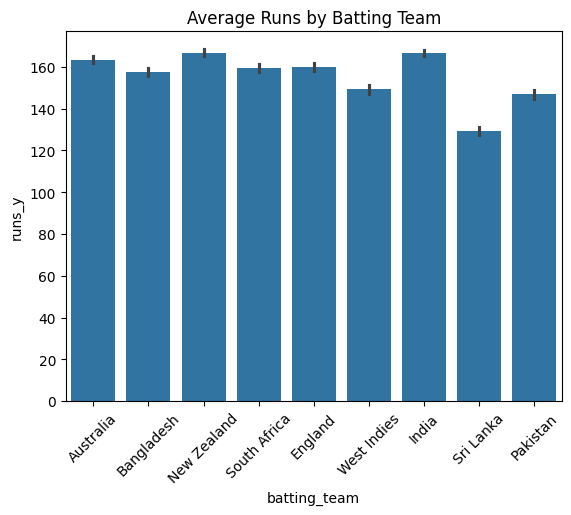

In [37]:
# DATA VISULAIZATION
sns.barplot(x='batting_team', y='runs_y', data=delivery_df, estimator='mean')
plt.xticks(rotation=45)
plt.title("Average Runs by Batting Team")
plt.show()



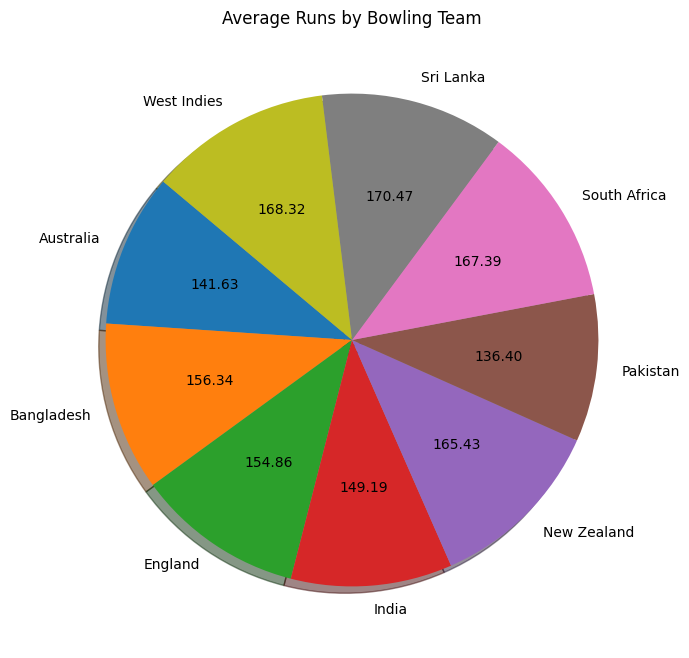

In [38]:
# Average runs per bowling team

avg_runs_per_team = delivery_df.groupby('bowling_team')['runs_y'].mean()

# Plot pie chart

plt.figure(figsize=(10,8))
avg_runs_per_team.plot(kind='pie', autopct=lambda pct: f"{pct * sum(avg_runs_per_team)/100:.2f}", startangle=140, shadow=True)
plt.title("Average Runs by Bowling Team")
plt.ylabel("")
plt.show()


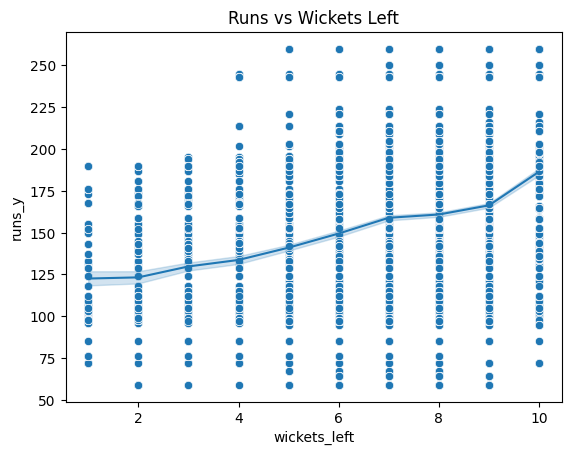

In [39]:
sns.scatterplot(x='wickets_left', y='runs_y', data=delivery_df)
sns.lineplot(x='wickets_left', y='runs_y', data=delivery_df, estimator='mean')
plt.title("Runs vs Wickets Left")
plt.show()


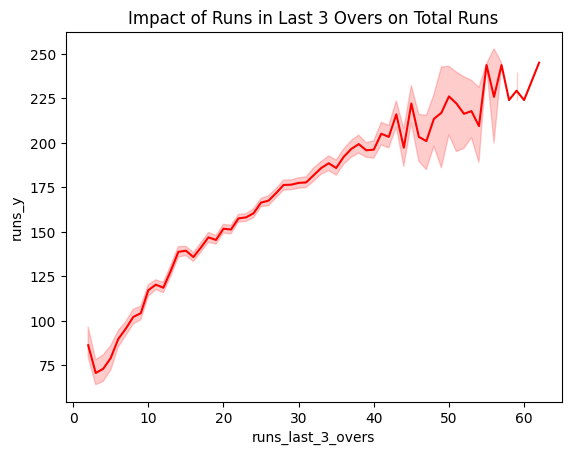

In [40]:
sns.lineplot(x='runs_last_3_overs', y='runs_y', data=delivery_df, color='red')
plt.title("Impact of Runs in Last 3 Overs on Total Runs")
plt.show()


In [41]:
delivery_df["city"].unique()

array(['Victoria', 'Napier', 'Mount Maunganui', 'Auckland', 'Southampton',
       'Taunton', 'Cardiff', 'Chester-le-Street', 'Kanpur', 'Nagpur',
       'Bangalore', 'Lauderhill', 'Colombo', 'Abu Dhabi', 'Nelson',
       'Bangkok', 'Hobart', 'Wellington', 'Hamilton', 'Bloemfontein',
       'Potchefstroom', 'Barbados', 'Trinidad', 'Sydney', 'Canberra',
       'Jamaica', 'Ranchi', 'Guwahati', 'Birmingham', 'Manchester',
       'Delhi', 'Rajkot', 'Thiruvananthapuram', 'Lahore', 'Johannesburg',
       'Centurion', 'Cape Town', 'Cuttack', 'Indore', 'Mumbai', 'Antigua',
       'East London', 'Bristol', 'Chelmsford', 'Dhaka', 'New Plymouth',
       'Karachi', 'Brisbane', 'St Kitts', 'Kuala Lumpur', 'Guyana',
       'St Lucia', 'Sylhet'], dtype=object)

In [42]:

# Sri Lanka
cities=['Colombo', 'Kandy', 'Dambulla', 'Hambantota',

# New Zealand
'Napier', 'Mount Maunganui', 'Auckland', 'Wellington', 'Hamilton', 'Christchurch', 'Dunedin', 'Nelson', 'Queenstown',

# Bangladesh
'Dhaka', 'Chattogram', 'Sylhet', 'Mirpur',

# England
'Southampton', 'Taunton', 'Cardiff', 'Chester-le-Street', 'Birmingham', 'Manchester', 'Nottingham', 'Leeds', 'Bristol', 'London',

# South Africa
'Bloemfontein', 'Potchefstroom', 'East London', 'Durban', 'Port Elizabeth', 'Gqeberha', 'Centurion', 'Cape Town', 'Paarl',

# India
'Kanpur', 'Nagpur', 'Bangalore', 'Bengaluru', 'Ranchi', 'Guwahati', 'Delhi', 'Rajkot', 'Thiruvananthapuram', 'Cuttack', 'Indore',
'Mumbai', 'Kolkata', 'Lucknow', 'Chennai', 'Visakhapatnam', 'Hyderabad', 'Chandigarh', 'Pune', 'Jaipur', 'Dharamsala',

# Pakistan
'Lahore', 'Karachi', 'Rawalpindi',

# Australia
'Hobart', 'Adelaide', 'Melbourne', 'Sydney', 'Canberra', 'Perth', 'Darwin', 'Cairns',

# West Indies / Caribbean
'Barbados', 'Trinidad', 'Jamaica', 'St Kitts', 'Gros Islet', 'Basseterre', 'Coolidge', 'Bridgetown', "St George's",
'Tarouba', 'Kingstown', 'St Lucia', 'Antigua', 'St Vincent', 'Providence', 'Guyana'
]


In [43]:
delivery_df = delivery_df[delivery_df["city"].isin(cities)]

In [44]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
392,8,Bangladesh,New Zealand,1,12,18,9,12,4.00,Napier,141
393,8,Bangladesh,New Zealand,6,18,19,9,18,5.68,Napier,141
394,8,Bangladesh,New Zealand,0,18,20,9,18,5.40,Napier,141
395,8,Bangladesh,New Zealand,1,19,21,9,18,5.43,Napier,141
396,8,Bangladesh,New Zealand,0,19,22,9,16,5.18,Napier,141
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14,9.91,Dhaka,190


In [52]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Batting team
le_batting = LabelEncoder()
delivery_df['batting_team'] = le_batting.fit_transform(delivery_df['batting_team'])
pickle.dump(le_batting, open('le_batting.pkl','wb'))

# Bowling team
le_bowling = LabelEncoder()
delivery_df['bowling_team'] = le_bowling.fit_transform(delivery_df['bowling_team'])
pickle.dump(le_bowling, open('le_bowling.pkl','wb'))

# City
le_city = LabelEncoder()
delivery_df['city'] = le_city.fit_transform(delivery_df['city'])
pickle.dump(le_city, open('le_city.pkl','wb'))

# Check encoded values
print(delivery_df['batting_team'].unique())
print(delivery_df['bowling_team'].unique())
print(delivery_df['city'].unique())


[1 4 6 2 8 3 7 5 0]
[4 1 2 6 0 5 8 7 3]
[30 27  1 35 40  9 11 23 29  2 12 31 20 43 19  5 32  3 42 38  7 22 34 17
  4 26 14 33 41 25 10  8 13 21 28  0 16  6 15 24 36 18 37 39]


In [53]:
print(delivery_df["batting_team"].unique())
print(delivery_df["bowling_team"].unique())
print(delivery_df["city"].unique())


[1 4 6 2 8 3 7 5 0]
[4 1 2 6 0 5 8 7 3]
[30 27  1 35 40  9 11 23 29  2 12 31 20 43 19  5 32  3 42 38  7 22 34 17
  4 26 14 33 41 25 10  8 13 21 28  0 16  6 15 24 36 18 37 39]


In [54]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y,batting_team_enc,bowling_team_enc,city_enc
392,8,1,4,1,12,18,9,12,4.00,30,141,1,4,30
393,8,1,4,6,18,19,9,18,5.68,30,141,1,4,30
394,8,1,4,0,18,20,9,18,5.40,30,141,1,4,30
395,8,1,4,1,19,21,9,18,5.43,30,141,1,4,30
396,8,1,4,0,19,22,9,17,5.18,30,141,1,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19325,233,8,1,0,189,112,2,17,10.12,15,190,8,1,15
19326,233,8,1,0,189,113,1,13,10.04,15,190,8,1,15
19327,233,8,1,0,189,114,1,13,9.95,15,190,8,1,15
19328,233,8,1,1,190,115,1,14,9.91,15,190,8,1,15


In [55]:
delivery_df=delivery_df.drop("match_id",axis=1)
delivery_df=delivery_df.drop("runs_x",axis=1)

In [56]:
# Train test split
from sklearn.model_selection import train_test_split
x=delivery_df.drop("runs_y",axis=1)
y=delivery_df["runs_y"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [57]:
x_train.shape

(9105, 11)

In [58]:
x_test.shape

(3035, 11)

In [59]:
update=delivery_df.copy()


In [60]:
x_train_update=x_train.copy()

In [61]:
x_test_update=x_test.copy()
y_train_update=y_train.copy()
y_test_update=y_test.copy()

In [62]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

<Axes: >

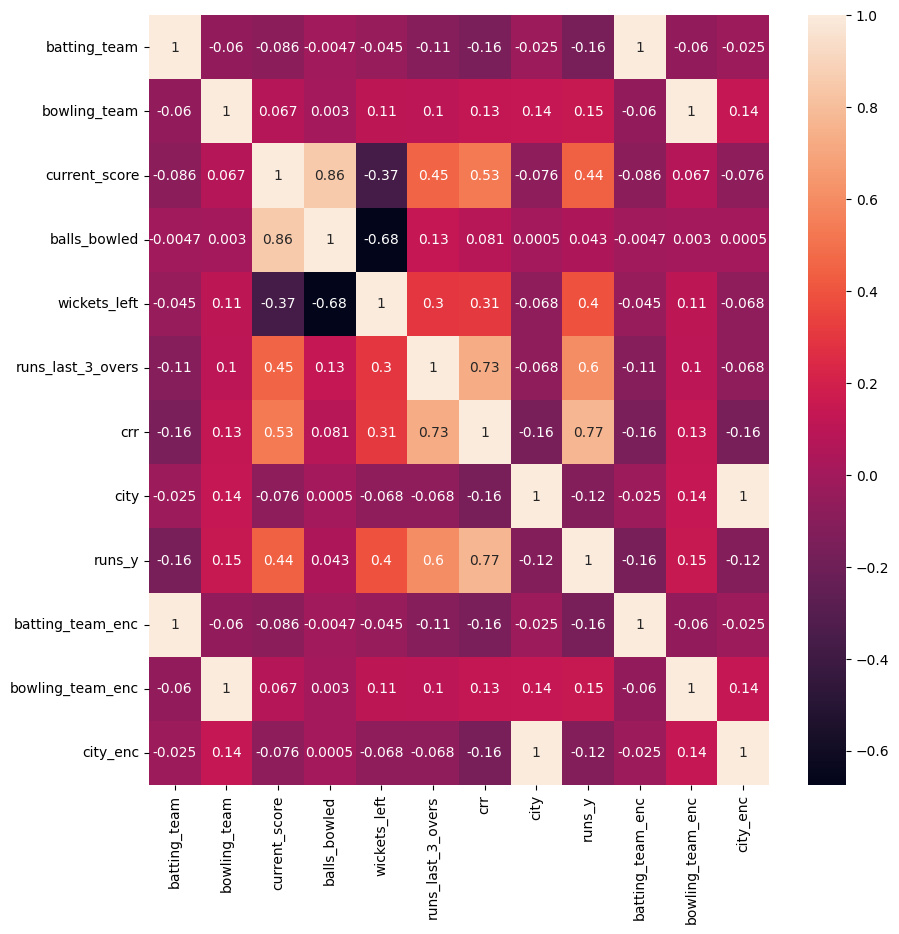

In [63]:
# feature engineering (best features)
plt.figure(figsize=(10,10))
sns.heatmap(delivery_df.corr(),annot=True)

In [64]:
# feature selection
from sklearn.feature_selection import mutual_info_classif
mutual=mutual_info_classif(x_train,y_train)
mutual
mutual=pd.Series(mutual)
mutual.index=x.columns
mutual.sort_values (ascending=False)

city_enc             2.975399
city                 2.973030
bowling_team         1.796692
bowling_team_enc     1.791889
batting_team_enc     1.767535
batting_team         1.758313
crr                  1.115962
runs_last_3_overs    0.452336
wickets_left         0.438406
current_score        0.359725
balls_bowled         0.000000
dtype: float64

In [65]:
y_train.shape

(9105,)

In [66]:
x_train.shape

(9105, 11)

In [67]:
# x_train = x_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)



In [68]:
x_train

array([[ 1.72102964, -0.72190845,  0.38519077, ...,  1.72102964,
        -0.72190845, -0.74458219],
       [-0.87033383, -0.34306255, -1.17711477, ..., -0.87033383,
        -0.34306255,  0.59839361],
       [-0.43843991,  0.79347517, -0.49226851, ..., -0.43843991,
         0.79347517, -0.82358077],
       ...,
       [ 1.72102964,  1.17232108,  1.02723414, ...,  1.72102964,
         1.17232108, -1.61356653],
       [-0.43843991, -0.72190845, -1.17711477, ..., -0.43843991,
        -0.72190845,  0.20340073],
       [-1.30222774, -0.34306255, -0.87749453, ..., -1.30222774,
        -0.34306255, -0.66558361]], shape=(9105, 11))

In [69]:
# Model training
# LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
lr=LinearRegression()
lr.fit(x_train,y_train)
lr_test_pred=lr.predict(x_test)
lr_train_pred=lr.predict(x_train)


In [70]:
lr_test_pred

array([168.5051346 , 162.27814286, 188.6898481 , ..., 125.62742123,
       133.9281871 , 217.08382851], shape=(3035,))

In [71]:
mae_1 = mean_absolute_error(y_test, lr_test_pred)
mse_1 = mean_squared_error(y_test, lr_test_pred)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test, lr_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - lr_test_pred) ** 2)
see_1 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_1)
print("MSE:", mse_1)
print("RMSE:", rmse_1)
print("R2 Score:", r2_1)
print("Standard Error of Estimate (SEE):", see_1)


----- REGRESSION METRICS -----
MAE: 16.576084813429485
MSE: 529.1132626101441
RMSE: 23.0024620988742
R2 Score: 0.6666975307122385
Standard Error of Estimate (SEE): 23.04807178430461


In [72]:
train_mae = (mean_absolute_error(y_train, lr_train_pred))
test_mae = (mean_absolute_error(y_test, lr_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")



Train MAE: 16.302127254846123
Test MAE: 16.576084813429485
Model is balanced.


In [66]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
param_lr={"fit_intercept":[True,False],"copy_X":[True,False],"n_jobs":[i for i in range(1,10)],"positive":[True,False]}
gc_lr=GridSearchCV(estimator=lr,param_grid=param_lr,cv=5,scoring="neg_mean_absolute_error")
gc_lr.fit(x_train,y_train)
print(gc_lr.best_params_)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}


In [68]:
# after hyperparameter tuning
lr_tuned=LinearRegression(copy_X=True,fit_intercept=True,n_jobs=1,positive=False)
lr_tuned.fit(x_train,y_train)
y_lr_tuned_test=lr_tuned.predict(x_test)
y_lr_tuned_train=lr_tuned.predict(x_train)


In [69]:
#evaluatiom after tuning
mae_2 = mean_absolute_error(y_test, y_lr_tuned_test)
mse_2 = mean_squared_error(y_test, y_lr_tuned_test)
rmse_2 = np.sqrt(mse_2)
r2_2= r2_score(y_test, y_lr_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - y_lr_tuned_test) ** 2)
see_2 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_2)
print("MSE:", mse_2)
print("RMSE:", rmse_2)
print("R2 Score:", r2_2)
print("Standard Error of Estimate (SEE):", see_2)


----- REGRESSION METRICS -----
MAE: 16.59149033851202
MSE: 530.4808425607304
RMSE: 23.032169731936467
R2 Score: 0.6659798704432573
Standard Error of Estimate (SEE): 23.066395710956957


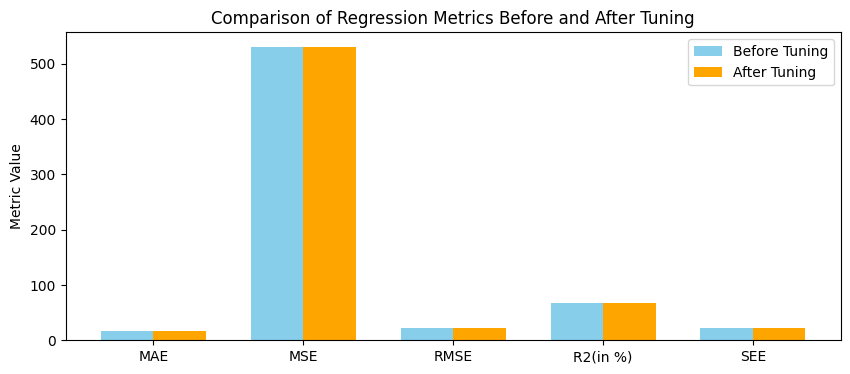

In [70]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_1, mse_1, rmse_1, r2_1*100, see_1]
after_values  = [mae_2, mse_2, rmse_2, r2_2*100, see_2]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [62]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(x_train,y_train)
dt_test_pred=dt.predict(x_test)
dt_train_pred=dt.predict(x_train)
print(dt_test_pred)

[160. 153. 185. ...  96. 118. 250.]


In [63]:
mae_3 = mean_absolute_error(y_test, dt_test_pred)
mse_3 = mean_squared_error(y_test, dt_test_pred)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test, dt_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - dt_test_pred) ** 2)
see_3 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_3)
print("MSE:", mse_3)
print("RMSE:", rmse_3)
print("R2 Score:", r2_3)
print("Standard Error of Estimate (SEE):", see_3)

NameError: name 'mean_absolute_error' is not defined

In [65]:
train_mae = (mean_absolute_error(y_train,dt_train_pred))
test_mae = (mean_absolute_error(y_test,dt_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 0.0019769357495881385
Test MAE: 0.9818780889621087
Model is OVERFITTING (High Variance).


In [282]:
# Hyperparameter tuning
param_dt={"max_depth":[i for i in range(1,10)],"min_samples_split":[j for j in range(1,5)],"min_samples_leaf":[m for m in range(1,5)] }
gc_dt=GridSearchCV(estimator=dt,param_grid=param_dt,cv=5)
gc_dt.fit(x_train,y_train)
print(gc_dt.best_params_)


{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}


C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

In [66]:
# after hyperparameter tuning
dt_tuned=DecisionTreeRegressor(max_depth=9, min_samples_leaf= 1, min_samples_split=4)
dt_tuned.fit(x_train,y_train)
dt_tuned_test=dt_tuned.predict(x_test)
dt_tuned_train=dt_tuned.predict(x_train)



In [71]:
#evaluatiom after tuning
mae_4 = mean_absolute_error(y_test, dt_tuned_test)
mse_4 = mean_squared_error(y_test, dt_tuned_test)
rmse_4 = np.sqrt(mse_4)
r2_4= r2_score(y_test, dt_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - dt_tuned_test) ** 2)
see_4 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_4)
print("MSE:", mse_4)
print("RMSE:", rmse_4)
print("R2 Score:", r2_4)
print("Standard Error of Estimate (SEE):", see_4)



----- REGRESSION METRICS -----
MAE: 6.799560328761148
MSE: 175.71435172426487
RMSE: 13.255729015194332
R2 Score: 0.889099943690361
Standard Error of Estimate (SEE): 13.275420626468641


In [67]:
train_mae = (mean_absolute_error(y_train,dt_tuned_train))
test_mae = (mean_absolute_error(y_test,dt_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 5.962938708584507
Test MAE: 6.4294014625667595
Model is balanced.


In [68]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_3, mse_3, rmse_3, r2_3*100, see_3]
after_values  = [mae_4, mse_4, rmse_4, r2_4*100, see_4]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

NameError: name 'mae_3' is not defined

In [78]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor()
rf.fit(x_train,y_train)
rf_test_pred=rf.predict(x_test)
rf_train_pred=rf.predict(x_train)


In [79]:
rf_test_pred

array([165.58, 153.73, 185.  , ..., 106.45, 119.09, 248.41], shape=(3035,))

In [80]:
mae_5 = mean_absolute_error(y_test, rf_test_pred)
mse_5 = mean_squared_error(y_test, rf_test_pred)
rmse_5 = np.sqrt(mse_5)
r2_5 = r2_score(y_test, rf_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - rf_test_pred) ** 2)
see_5 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_5)
print("MSE:", mse_5)
print("RMSE:", rmse_5)
print("R2 Score:", r2_5)
print("Standard Error of Estimate (SEE):", see_5)

----- REGRESSION METRICS -----
MAE: 1.846194398682043
MSE: 31.11681146622735
RMSE: 5.578244478886467
R2 Score: 0.9804071314862759
Standard Error of Estimate (SEE): 5.586533792517254


In [81]:
train_mae = (mean_absolute_error(y_train,rf_train_pred))
test_mae = (mean_absolute_error(y_test,rf_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 0.7713476112026362
Test MAE: 1.846194398682043
Model is OVERFITTING (High Variance).


In [63]:
# ====== IMPORTS ======
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# ====== DEFINE ESTIMATOR ======
rf = RandomForestRegressor(random_state=42)

# ====== HYPERPARAMETER GRID ======
param_rf = {
    "n_estimators": [100, 200],
    "max_depth": [i for i in range(1, 5)]
}

# ====== GRID SEARCH ======
gc_rf = GridSearchCV(estimator=rf, param_grid=param_rf, cv=5)
gc_rf.fit(x_train, y_train)  # Make sure X_train and y_train exist
print("Best parameters:", gc_rf.best_params_)


Best parameters: {'max_depth': 4, 'n_estimators': 200}


In [82]:
# after hyperparameter tuning
rf_tuned=RandomForestRegressor(max_depth=9, n_estimators=800)
rf_tuned.fit(x_train,y_train)
rf_tuned_test=rf_tuned.predict(x_test)
rf_tuned_train=rf_tuned.predict(x_train)



In [83]:
#evaluatiom after tuning
mae_6 = mean_absolute_error(y_test, rf_tuned_test)
mse_6 = mean_squared_error(y_test, rf_tuned_test)
rmse_6 = np.sqrt(mse_6)
r2_6= r2_score(y_test, rf_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - rf_tuned_test) ** 2)
see_6 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_6)
print("MSE:", mse_6)
print("RMSE:", rmse_6)
print("R2 Score:", r2_6)
print("Standard Error of Estimate (SEE):", see_6)


----- REGRESSION METRICS -----
MAE: 6.476392017807697
MSE: 106.11720521548085
RMSE: 10.301320556874291
R2 Score: 0.9331827282147017
Standard Error of Estimate (SEE): 10.31662839740197


In [84]:

train_mae = (mean_absolute_error(y_train,rf_tuned_train))
test_mae = (mean_absolute_error(y_test,rf_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 5.8580736857836895
Test MAE: 6.476392017807697
Model is balanced.


In [85]:
# XGBOOST
from xgboost import XGBRegressor
xg=XGBRegressor()
xg.fit(x_train,y_train)
xg_test_pred=xg.predict(x_test)
xg_train_pred=xg.predict(x_train)
print(xg_test_pred)

[164.00186 165.97176 167.6514  ...  98.96796 123.26481 177.22113]


In [86]:
mae_7 = mean_absolute_error(y_test, xg_test_pred)
mse_7 = mean_squared_error(y_test, xg_test_pred)
rmse_7 = np.sqrt(mse_7)
r2_7 = r2_score(y_test, xg_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - xg_test_pred) ** 2)
see_7 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_7)
print("MSE:", mse_7)
print("RMSE:", rmse_7)
print("R2 Score:", r2_7)
print("Standard Error of Estimate (SEE):", see_7)

----- REGRESSION METRICS -----
MAE: 14.288187026977539
MSE: 442.7687072753906
RMSE: 21.042069937993045
R2 Score: 0.7212083339691162
Standard Error of Estimate (SEE): 21.073337827656704


In [87]:
train_mae = (mean_absolute_error(y_train,xg_train_pred))
test_mae = (mean_absolute_error(y_test,xg_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 1.8446400165557861
Test MAE: 14.288187026977539
Model is OVERFITTING (High Variance).


In [298]:
# Hyperparameter tuning
param_xg={'n_estimators': [100, 200, 300,500,800],"max_depth":[ l for  l in range(1,3)],"learning_rate": [0.01, 0.05, 0.1, 0.2],"verbosity":[ r for r in range(0,3)] }
gc_xg=GridSearchCV(estimator=xg,param_grid=param_xg,cv=5)
gc_xg.fit(x_train,y_train)
print(gc_xg.best_params_)

[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7284, 8, 58272).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iter

In [88]:
# after hyperparameter tuning
xg_tuned=XGBRegressor(learning_rate=0.01,max_depth=2,n_estimators=800,verbosity=0)
xg_tuned.fit(x_train,y_train)
xg_tuned_test=xg_tuned.predict(x_test)
xg_tuned_train=xg_tuned.predict(x_train)

In [89]:
#evaluatiom after tuning
mae_8 = mean_absolute_error(y_test, xg_tuned_test)
mse_8 = mean_squared_error(y_test, xg_tuned_test)
rmse_8 = np.sqrt(mse_8)
r2_8= r2_score(y_test, xg_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - xg_tuned_test) ** 2)
see_8 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_8)
print("MSE:", mse_8)
print("RMSE:", rmse_8)
print("R2 Score:", r2_8)
print("Standard Error of Estimate (SEE):", see_8)



----- REGRESSION METRICS -----
MAE: 16.049707412719727
MSE: 501.063232421875
RMSE: 22.384441749167546
R2 Score: 0.6845028400421143
Standard Error of Estimate (SEE): 22.417705043960147


In [90]:
train_mae = (mean_absolute_error(y_train,xg_tuned_train))
test_mae = (mean_absolute_error(y_test,xg_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 14.017845153808594
Test MAE: 16.049707412719727
Model is balanced.


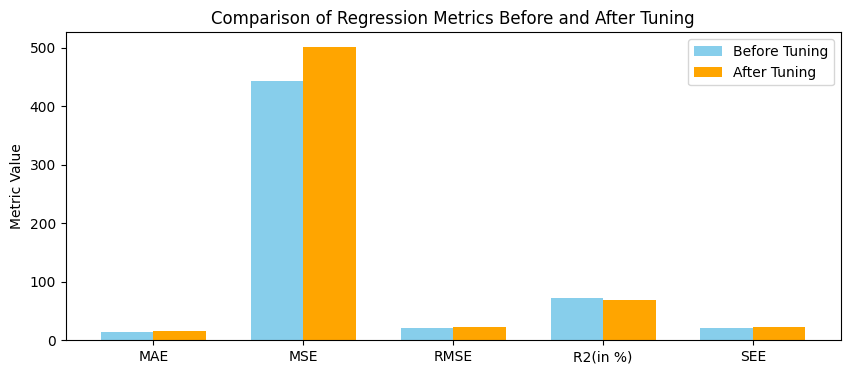

In [91]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_7, mse_7, rmse_7, r2_7*100, see_7]
after_values  = [mae_8, mse_8, rmse_8, r2_8*100, see_8]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [92]:
from sklearn.neighbors import KNeighborsRegressor
kn=KNeighborsRegressor()
kn.fit(x_train,y_train)
kn_test_pred=kn.predict(x_test)
kn_train_pred=kn.predict(x_train)
print(kn_test_pred)

[160. 153. 185. ...  96. 118. 250.]


In [93]:
mae_11 = mean_absolute_error(y_test, kn_test_pred)
mse_11= mean_squared_error(y_test, kn_test_pred)
rmse_11 = np.sqrt(mse_11)
r2_11 = r2_score(y_test, kn_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - kn_test_pred) ** 2)
see_11 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_11)
print("MSE:", mse_11)
print("RMSE:", rmse_11)
print("R2 Score:", r2_11)
print("Standard Error of Estimate (SEE):", see_11)

----- REGRESSION METRICS -----
MAE: 1.1184184514003295
MSE: 30.525416803953878
RMSE: 5.524981158696732
R2 Score: 0.9807795063316297
Standard Error of Estimate (SEE): 5.5331913226294835


In [94]:
train_mae = (mean_absolute_error(y_train,kn_train_pred))
test_mae = (mean_absolute_error(y_test,kn_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 0.7362987369577154
Test MAE: 1.1184184514003295
Model is OVERFITTING (High Variance).


In [314]:
# Hyperparameter tuning
param_kn={"n_neighbors":[5,10,15,20],"weights":['uniform', 'distance']}
gc_kn=GridSearchCV(estimator=kn,param_grid=param_kn,cv=2)
gc_kn.fit(x_train,y_train)
print(gc_kn.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [95]:
kn_tuned=KNeighborsRegressor(n_neighbors=5,weights= 'distance')
kn_tuned.fit(x_train,y_train)
kn_tuned_test=kn_tuned.predict(x_test)
kn_tuned_train=kn_tuned.predict(x_train)

In [96]:
mae_12= mean_absolute_error(y_test,kn_tuned_test)
mse_12= mean_squared_error(y_test,kn_tuned_test)
rmse_12 = np.sqrt(mse_12)
r2_12 = r2_score(y_test,kn_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - kn_test_pred) ** 2)
see_12 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_12)
print("MSE:", mse_12)
print("RMSE:", rmse_12)
print("R2 Score:", r2_12)
print("Standard Error of Estimate (SEE):", see_12)

----- REGRESSION METRICS -----
MAE: 0.8301202988786617
MSE: 21.893389982466047
RMSE: 4.679037292271354
R2 Score: 0.986214708672458
Standard Error of Estimate (SEE): 5.5331913226294835


In [97]:
train_mae = (mean_absolute_error(y_train,kn_tuned_train))
test_mae = (mean_absolute_error(y_test,kn_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 0.0
Test MAE: 0.8301202988786617
Model is OVERFITTING (High Variance).


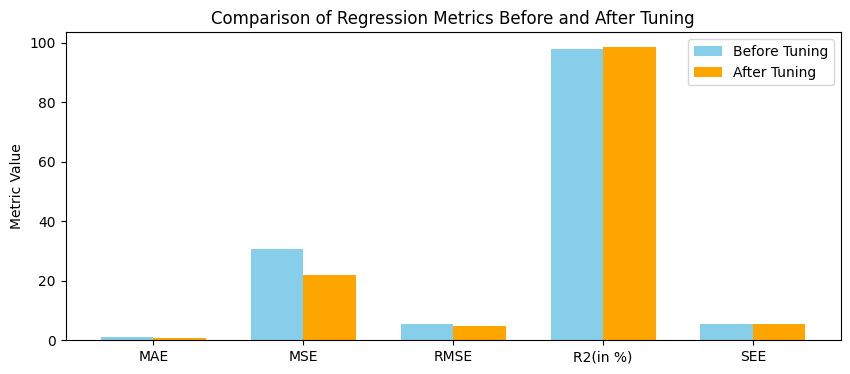

In [98]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_11, mse_11, rmse_11, r2_11*100, see_11]
after_values  = [mae_12, mse_12, rmse_12, r2_12*100, see_12]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [99]:
# REGULARIZATION TECHNIQUE
from sklearn.linear_model import Ridge


# Create Ridge model
ridge = Ridge(alpha=1.0)  # alpha is the regularization strength

# Train the model
ridge.fit(x_train, y_train)

# Predictions
y_train_r = ridge.predict(x_train)
y_test_r = ridge.predict(x_test)

# Evaluation
print("Ridge Regression MAE (train):", mean_absolute_error(y_train, y_train_r))
print("Ridge Regression MAE(test):", mean_absolute_error(y_test, y_test_r))
print("Ridge Regression r2 (test):", r2_score(y_test, y_test_r))


Ridge Regression MAE (train): 16.294392866879402
Ridge Regression MAE(test): 16.5905998629768
Ridge Regression r2 (test): 0.6659739839146646


In [100]:
train_mae = (mean_absolute_error(y_train,y_train_r))
test_mae = (mean_absolute_error(y_test,y_test_r))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.294392866879402
Test MAE: 16.5905998629768
Model is balanced.


In [100]:
# Hyperparameter tuning
param_ridge= {'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500, 1000],'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
gc_ridge=GridSearchCV(estimator=ridge,param_grid=param_ridge,cv=5)
gc_ridge.fit(x_train,y_train)
print(gc_ridge.best_params_)

{'alpha': 0.001, 'solver': 'saga'}


In [101]:
# after hyperparameter tuning
ridge_tuned=Ridge(alpha=0.001,solver="sag")
ridge_tuned.fit(x_train,y_train)
ridge_tuned_test=ridge_tuned.predict(x_test)
ridge_tuned_train=ridge_tuned.predict(x_train)

In [102]:
#evaluatiom after tuning
mae_14 = mean_absolute_error(y_test, ridge_tuned_test)
mse_14 = mean_squared_error(y_test, ridge_tuned_test)
rmse_14 = np.sqrt(mse_14)
r2_14= r2_score(y_test, ridge_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - ridge_tuned_test) ** 2)
see_14 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_14)
print("MSE:", mse_14)
print("RMSE:", rmse_14)
print("R2 Score:", r2_14)
print("Standard Error of Estimate (SEE):", see_14)


----- REGRESSION METRICS -----
MAE: 16.591480812411827
MSE: 530.4801162470378
RMSE: 23.032153964556546
R2 Score: 0.6659803277705993
Standard Error of Estimate (SEE): 23.06637992014659


In [103]:
train_mae = (mean_absolute_error(y_train,ridge_tuned_train))
test_mae = (mean_absolute_error(y_test,ridge_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.29518671234711
Test MAE: 16.591480812411827
Model is balanced.


In [104]:
from sklearn.linear_model import Lasso

# Create Lasso model
lasso = Lasso(alpha=0.01)  # alpha is the regularization strength

# Train the model
lasso.fit(x_train, y_train)

# Predictions
y_train_l = lasso.predict(x_train)
y_test_l = lasso.predict(x_test)

# Evaluation
print("Lasso Regression MAE(train):", mean_absolute_error(y_train, y_train_l))
print("Lasso Regression MAE(test):", mean_absolute_error(y_test, y_test_l))
print("Lasso Regression r2 (test):", r2_score(y_test, y_test_l))


Lasso Regression MAE(train): 16.29157507391267
Lasso Regression MAE(test): 16.587876978527802
Lasso Regression r2 (test): 0.6659639191995903


In [105]:
train_mae = (mean_absolute_error(y_train,y_train_l))
test_mae = (mean_absolute_error(y_test,y_test_l))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.29157507391267
Test MAE: 16.587876978527802
Model is balanced.


In [106]:
# Hyperparameter tuning

param_lasso= {
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'max_iter': [1000, 5000, 10000]  # number of iterations for convergence
}

gc_lasso=GridSearchCV(estimator=lasso,param_grid=param_lasso,cv=5)
gc_lasso.fit(x_train,y_train)
print(gc_lasso.best_params_)

{'alpha': 0.0001, 'max_iter': 1000}


In [107]:
# after hyperparameter tuning
lasso_tuned=Ridge(alpha=0.0001,max_iter=1000)
lasso_tuned.fit(x_train,y_train)
lasso_tuned_test=lasso_tuned.predict(x_test)
lasso_tuned_train=lasso_tuned.predict(x_train)

In [108]:
#evaluatiom after tuning
mae_16 = mean_absolute_error(y_test, lasso_tuned_test)
mse_16 = mean_squared_error(y_test, lasso_tuned_test)
rmse_16 = np.sqrt(mse_16)
r2_16= r2_score(y_test, lasso_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - lasso_tuned_test) ** 2)
see_16 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_16)
print("MSE:", mse_16)
print("RMSE:", rmse_16)
print("R2 Score:", r2_16)
print("Standard Error of Estimate (SEE):", see_16)


----- REGRESSION METRICS -----
MAE: 16.591490249152834
MSE: 530.4808434623598
RMSE: 23.03216975150973
R2 Score: 0.6659798698755415
Standard Error of Estimate (SEE): 23.066395730559307


In [109]:
train_mae = (mean_absolute_error(y_train,lasso_tuned_train))
test_mae = (mean_absolute_error(y_test,lasso_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.295221679839624
Test MAE: 16.591490249152834
Model is balanced.


In [69]:
# ADA BOOST REGRESSOR
from sklearn.ensemble import AdaBoostRegressor
ad=AdaBoostRegressor(random_state=42)
ad.fit(x_train,y_train)
y_train_ad = ad.predict(x_train)
y_test_ad = ad.predict(x_test)
mae_17=mean_absolute_error(y_test, y_test_ad)
mse_17 = mean_squared_error(y_test, y_test_ad)
rmse_17 = np.sqrt(mse_17)
r2_17= r2_score(y_test, y_test_ad)
print(" MAE(train):", mean_absolute_error(y_train, y_train_ad))
print(" MAE(test):", mean_absolute_error(y_test, y_test_ad))
print(" r2 (test):", r2_score(y_test, y_test_ad))
print("MSE",mse_17)
print("RMSE",rmse_17)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - y_test_ad) ** 2)
see_17= np.sqrt(ssr / (n - k - 1))
print("Standard error of estimate :",see_17)

 MAE(train): 19.232687559410248
 MAE(test): 19.503023753803635
 r2 (test): 0.6362324936740645
MSE 577.8563736565177
RMSE 24.038643340598856
Standard error of estimate : 24.074364947040284


In [74]:
train_mae = (mean_absolute_error(y_train,y_train_ad))
test_mae = (mean_absolute_error(y_test,y_test_ad))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 18.683987388672428
Test MAE: 19.234129776432063
Model is balanced.


In [ ]:
# Hyperparameter tuning
param_ad= {"n_estimators":[50,100,150,300],"loss" : ['linear', 'square', 'exponential'],"learning_rate":[0.5,1]}
gc_ad=GridSearchCV(estimator=ad,param_grid=param_ad,cv=5)
gc_ad.fit(x_train,y_train)
print(gc_ad.best_params_)

In [70]:
# AFTER TUNING
ad_tuned=AdaBoostRegressor(estimator=dt_tuned,n_estimators=150,loss="linear",learning_rate=0.5,random_state=42)
ad_tuned.fit(x_train,y_train)
ad_tuned_train = ad_tuned.predict(x_train)
ad_tuned_test = ad_tuned.predict(x_test)
print(" MAE(train):", mean_absolute_error(y_train, ad_tuned_train))
print(" MAE(test):", mean_absolute_error(y_test, ad_tuned_test))
print(" r2 (test):", r2_score(y_test, ad_tuned_test))
print(ad_tuned_test[:10])

 MAE(train): 2.1752493490669513
 MAE(test): 2.3876466065491764
 r2 (test): 0.983293559567272
[170.27118644 155.66666667 185.         167.         158.77586207
 150.92653061 124.         192.         180.02914798 174.        ]


In [71]:
#evaluatiom after tuning
mae_18 = mean_absolute_error(y_test, ad_tuned_test)
mse_18 = mean_squared_error(y_test, ad_tuned_test)
rmse_18 = np.sqrt(mse_18)
r2_18= r2_score(y_test, ad_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - ad_tuned_test) ** 2)
see_18 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_18)
print("MSE:", mse_18)
print("RMSE:", rmse_18)
print("R2 Score:", r2_18)
print("Standard Error of Estimate (SEE):", see_18)

----- REGRESSION METRICS -----
MAE: 2.3876466065491764
MSE: 26.538717497529518
RMSE: 5.151574273707943
R2 Score: 0.983293559567272
Standard Error of Estimate (SEE): 5.159229552175692


In [72]:
train_mae = (mean_absolute_error(y_train,ad_tuned_train))
test_mae = (mean_absolute_error(y_test,ad_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 2.1752493490669513
Test MAE: 2.3876466065491764
Model is balanced.


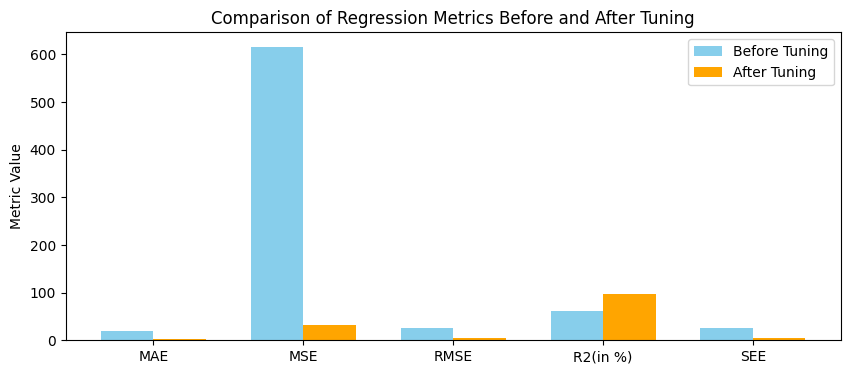

In [114]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_17, mse_17, rmse_17, r2_17*100, see_17]
after_values  = [mae_18, mse_18, rmse_18, r2_18*100, see_18]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [115]:
# Comparing different algorithms 
compare= {
    "Algorithm": ["Linear Regression(U)","DecisionTree(B)","Random Forest(B)", "K nearest Neighbour(O)","XGBooster(B)","Ridge(U)","Lasso(U)","ADABosster(B)"],
    "MAE":  [mae_2,mae_4,mae_6,mae_12,mae_8,mae_14,mae_16,mae_18],
    "MSE":  [mse_2,mse_4,mse_6,mse_12,mse_8,mse_14,mse_16,mse_18],
    "RMSE": [rmse_2,rmse_4,rmse_6,rmse_12,rmse_8,rmse_14,rmse_16,rmse_18],
    "R2":   [r2_2,r2_4,r2_6,r2_12,r2_8,r2_14,r2_16,r2_18],
}

comparision = pd.DataFrame(compare)
print(comparision)


                Algorithm        MAE         MSE       RMSE        R2
0    Linear Regression(U)  16.591490  530.480843  23.032170  0.665980
1         DecisionTree(B)   6.494110  141.899087  11.912140  0.910652
2        Random Forest(B)   6.476392  106.117205  10.301321  0.933183
3  K nearest Neighbour(O)   0.830120   21.893390   4.679037  0.986215
4            XGBooster(B)  16.049707  501.063232  22.384442  0.684503
5                Ridge(U)  16.591481  530.480116  23.032154  0.665980
6                Lasso(U)  16.591490  530.480843  23.032170  0.665980
7           ADABosster(B)   2.874864   32.669135   5.715692  0.979430


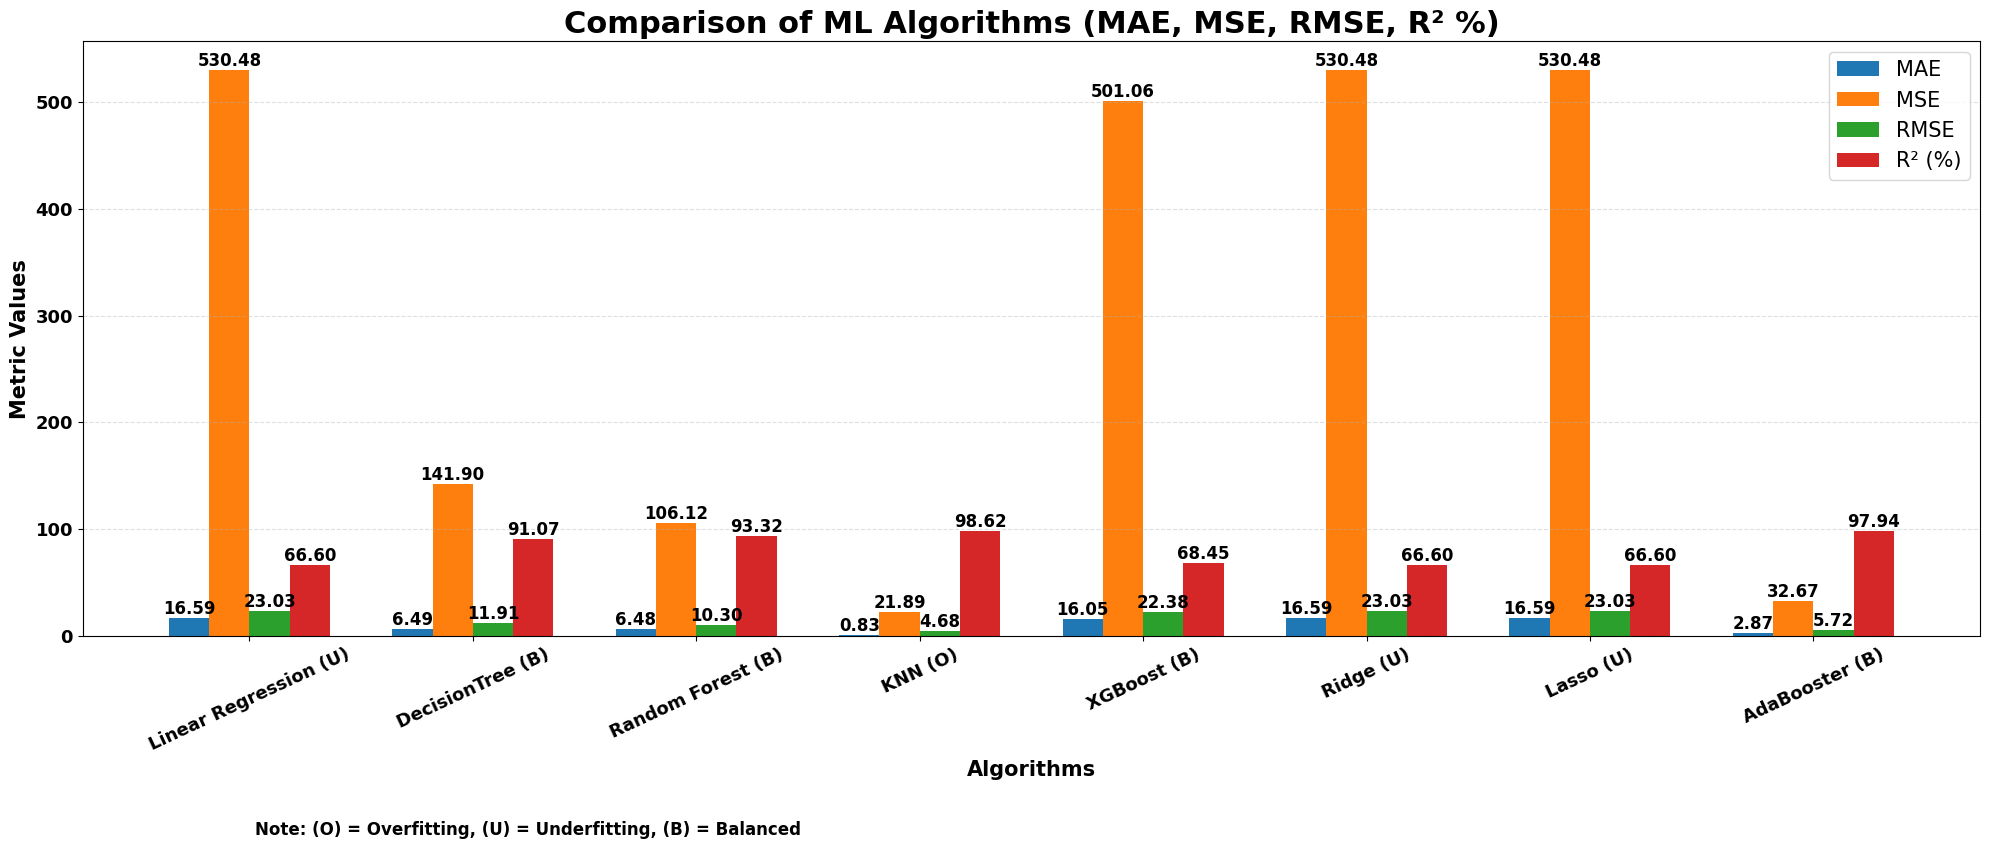

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Algorithm = [
    "Linear Regression (U)",
    "DecisionTree (B)",
    "Random Forest (B)",
    "KNN (O)",
    "XGBoost (B)",
    "Ridge (U)",
    "Lasso (U)",
    "AdaBooster (B)"
]

MAE  = [mae_2, mae_4, mae_6, mae_12, mae_8, mae_14, mae_16, mae_18]
MSE  = [mse_2, mse_4, mse_6, mse_12, mse_8, mse_14, mse_16, mse_18]
RMSE = [rmse_2, rmse_4, rmse_6, rmse_12, rmse_8, rmse_14, rmse_16, rmse_18]
R2   = [r2_2*100, r2_4*100, r2_6*100, r2_12*100, r2_8*100, r2_14*100, r2_16*100, r2_18*100]


x = np.arange(len(Algorithm))
width = 0.18

plt.figure(figsize=(20,8))

bars1 = plt.bar(x - 1.5*width, MAE,  width, label='MAE')
bars2 = plt.bar(x - 0.5*width, MSE,  width, label='MSE')
bars3 = plt.bar(x + 0.5*width, RMSE, width, label='RMSE')
bars4 = plt.bar(x + 1.5*width, R2,   width, label='R² (%)')


# Adding labels to bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f"{height:.2f}",
            ha='center', va='bottom',
            fontsize=12, fontweight='bold'
        )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)


# Styling
plt.xticks(x, Algorithm, rotation=25, fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xlabel("Algorithms", fontsize=15, fontweight='bold')
plt.ylabel("Metric Values", fontsize=15, fontweight='bold')

plt.title("Comparison of ML Algorithms (MAE, MSE, RMSE, R² %)",
          fontsize=22, fontweight='bold')

plt.legend(fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.4)


plt.figtext(0.13, -0.05, 
            "Note: (O) = Overfitting, (U) = Underfitting, (B) = Balanced", 
            fontsize=12, fontweight='bold', ha='left')


plt.tight_layout()

plt.show()


In [73]:
# Ensemble techniques
# best model till now KNN,Ada booster
# stacking
from sklearn.ensemble import VotingRegressor
voting_reg = VotingRegressor(
    estimators=[('dt_tuned', dt_tuned), ('ad', ad_tuned)],
    weights=[0.7, 0.5]   
)

# Train the ensemble
voting_reg.fit(x_train, y_train)

# Make predictions
y_test_v = voting_reg.predict(x_test)
y_train_v = voting_reg.predict(x_train)

mae_19=mean_absolute_error(y_test, y_test_v)
mse_19 = mean_squared_error(y_test, y_test_v)
rmse_19 = np.sqrt(mse_19)
r2_19= r2_score(y_test, y_test_v)
print(" MAE(train):", mean_absolute_error(y_train, y_train_v))
print(" MAE(test):", mean_absolute_error(y_test, y_test_v))
print(" r2 (test):", r2_score(y_test, y_test_v))
print("MSE",mse_19)
print("RMSE",rmse_19)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - y_test_v) ** 2)
see_19= np.sqrt(ssr / (n - k - 1))
print("Standard error of estimate :",see_19)

 MAE(train): 4.184283373140671
 MAE(test): 4.54850643751965
 r2 (test): 0.9567950847600105
MSE 68.63239627111673
RMSE 8.284467168811567
Standard error of estimate : 8.29677794989801


In [74]:
train_mae = (mean_absolute_error(y_train,y_train_v))
test_mae = (mean_absolute_error(y_test,y_test_v))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 4.184283373140671
Test MAE: 4.54850643751965
Model is balanced.


In [75]:
import pandas as pd

# Create a DataFrame to compare
comparison = pd.DataFrame({
    'True Value': y_test[:15],
    'Predicted Value': y_test_v[:15]
})

print(comparison)


       True Value  Predicted Value
9733          160       164.279661
17463         153       154.111111
840           185       188.833623
18179         167       165.147059
11664         152       159.128276
1525          144       156.763832
4924          124       120.283951
13885         192       191.750290
7705          188       184.678812
1262          176       176.784413
12780          72        72.000000
12668         124       117.589557
1641          202       152.333333
11393         139       151.885396
609           195       198.005115


In [119]:
delivery_df.head()

,batting_team,bowling_team,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
392,1,4,12,18,9,12,4.00,30,141
393,1,4,18,19,9,18,5.68,30,141
394,1,4,18,20,9,18,5.40,30,141
395,1,4,19,21,9,18,5.43,30,141
396,1,4,19,22,9,17,5.18,30,141


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yaml import safe_load
import os
from tqdm import tqdm
%matplotlib inline
from sklearn.model_selection import train_test_split

x = delivery_df.drop(['match_id', 'runs_y','runs_x'], axis=1)  # drop match_id and target
y = delivery_df['runs_y']  # target

# Automatically detect categorical and numeric columns
categorical_cols = ['batting_team', 'bowling_team', 'city']
numeric_cols = [col for col in x.columns if col not in categorical_cols]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)
pipeline_ordinal_nik = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', VotingRegressor(
        estimators=[
            ('ada', AdaBoostRegressor(
                estimator=DecisionTreeRegressor(
                    max_depth=9, min_samples_leaf=1, min_samples_split=4
                ),
                n_estimators=150, loss="linear", learning_rate=0.5, random_state=42
            )),
            ('dt', DecisionTreeRegressor(
                max_depth=9, min_samples_leaf=1, min_samples_split=4
            ))
        ],
        weights=[0.7, 0.5]
    ))
])
pipeline_ordinal_nik.fit(x_train, y_train)

# Predict
y_pred_ordinal_nik = pipeline_ordinal_nik.predict(x_test)

# Metrics
print("R2 Score:", r2_score(y_test, y_pred_ordinal_nik))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_ordinal_nik))

R2 Score: 0.9660840483967411
Mean Absolute Error: 4.124749214460426


In [47]:
comparison = pd.DataFrame({
    'True Value': y_test[:15],
    'Predicted Value': y_pred_ordinal_nik[:15]
})

print(comparison)


       True Value  Predicted Value
12566         139       144.165165
9924          148       148.000000
840           185       188.375668
18179         167       170.527644
11662         152       159.378151
1525          144       164.362626
4925          124       126.514535
16947         106       104.760870
7706          188       179.021027
1262          176       173.304311
12779          72        72.000000
12667         124       131.725116
1641          202       181.751603
12617         124       139.166667
609           195       198.258536


In [48]:
with open('pipeline_ordinal_nik.pkl', 'wb') as f:
    pickle.dump(pipeline_ordinal_nik, f)

In [124]:
pipeline_ordinal_nik

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['current_score',
                                                   'balls_bowled',
                                                   'wickets_left',
                                                   'runs_last_3_overs',
                                                   'crr']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('regressor',
                 VotingRegressor(estimators=[('dt',
                                              DecisionTreeRegressor(max_depth=9,
                                                                    min_samples_split=4)),
                                             ('ada',
                                              AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=9,
                                                                                                min_samples_split=4),
                                                                learning_rate=0.5,
                                                                n_estimators=150,
                                                                random_state=42))],
                                 weights=[0.5, 0.7]))])

In [126]:
# pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['current_score',
                                                   'balls_bowled',
                                                   'wickets_left',
                                                   'runs_last_3_overs',
                                                   'crr']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('regressor',
                 VotingRegressor(estimators=[('dt',
                                              DecisionTreeRegressor(max_depth=9,
                                                                    min_samples_split=4)),
                                             ('ada',
                                              AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=9,
                                                                                                min_samples_split=4),
                                                                learning_rate=0.5,
                                                                n_estimators=150,
                                                                random_state=42))],
                                 weights=[0.5, 0.7]))])

array([139.58333333, 151.29545455, 104.75925926, ..., 133.75      ,
       119.08333333, 149.5       ], shape=(3035,))

First 5 true values of x_test targets:
9733     160
17463    153
840      185
18179    167
11663    152
Name: runs_y, dtype: int64
First 5 predicted values:
[139.58333333 151.29545455 104.75925926 137.83333333 122.70506108]


NameError: name 'pipe' is not defined

array(['current_score', 'balls_bowled', 'wickets_left',
       'runs_last_3_overs', 'crr', 'batting_team', 'bowling_team', 'city'],
      dtype=object)

Batting Team Categories:
 [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Bowling Team Categories:
 [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
City Categories:
 [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43)]


[array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])]


Feature 0 categories: [0 1 2 3 4 5 6 7 8]
Feature 1 categories: [0 1 2 3 4 5 6 7 8]
Feature 2 categories: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]



batting_team mapping:
  0 → 0
  1 → 1
  2 → 2
  3 → 3
  4 → 4
  5 → 5
  6 → 6
  7 → 7
  8 → 8

bowling_team mapping:
  0 → 0
  1 → 1
  2 → 2
  3 → 3
  4 → 4
  5 → 5
  6 → 6
  7 → 7
  8 → 8

city mapping:
  0 → 0
  1 → 1
  2 → 2
  3 → 3
  4 → 4
  5 → 5
  6 → 6
  7 → 7
  8 → 8
  9 → 9
  10 → 10
  11 → 11
  12 → 12
  13 → 13
  14 → 14
  15 → 15
  16 → 16
  17 → 17
  18 → 18
  19 → 19
  20 → 20
  21 → 21
  22 → 22
  23 → 23
  24 → 24
  25 → 25
  26 → 26
  27 → 27
  28 → 28
  29 → 29
  30 → 30
  31 → 31
  32 → 32
  33 → 33
  34 → 34
  35 → 35
  36 → 36
  37 → 37
  38 → 38
  39 → 39
  40 → 40
  41 → 41
  42 → 42
  43 → 43
